### Basic Imports

In [15]:
import numpy as np 
import time
import matplotlib.pyplot as plt
import pandas as pd
# Retina display
%config InlineBackend.figure_format = 'retina'

In [2]:
log_size = 8
size = 2**log_size

def create_data(size=2**10, random_seed=0):
    np.random.seed(random_seed)
    A = np.random.rand(size,size)
    B = np.random.rand(size,size)
    return A, B

In [3]:
A, B = create_data(size=size)

In [4]:
# Naive implementation
def naive_multiply(A, B):
    C = np.zeros_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for k in range(A.shape[0]):
                C[i,j] += A[i,k] * B[k,j]
    return C

In [5]:
# Modify the Timer class to handle exceptions during the timing
class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        self.end_time = time.time()
        self.elapsed = self.end_time - self.start_time

# Define a function to run and time different matrix multiplications
def run_and_time_multiplication(function, n_times, *args, **kwargs):
    elapsed_times = []
    for _ in range(n_times):
        with Timer() as timer:
            result = function(*args, **kwargs)
        elapsed_times.append(timer.elapsed)
    return np.array(elapsed_times), result

In [6]:
# Number of times to run the timing code
n_times = 10

# Time Naive multiplication
naive_times, C_naive = run_and_time_multiplication(naive_multiply, n_times, A, B)
print(f"Naive Multiplication Times: {naive_times.mean():0.3f} +/- {naive_times.std():0.3f}")

Naive Multiplication Times: 8.541 +/- 0.016


In [7]:
def divide_matrix_four_parts(A):
    n = A.shape[0]//2
    A11 = A[:n,:n]
    A12 = A[:n,n:]
    A21 = A[n:,:n]
    A22 = A[n:,n:]
    return A11, A12, A21, A22

In [8]:
A11, A12, A21, A22 = divide_matrix_four_parts(A)

In [9]:
A.shape

(256, 256)

In [10]:
A11.shape

(128, 128)

In [11]:
def strassen_multiply(A, B, threshold=32):
    # if A and B are threshold X threshold matrices directly multiply them
    if A.shape[0] <= threshold:
        return naive_multiply(A, B)
    else:
        A11, A12, A21, A22 = divide_matrix_four_parts(A)
        B11, B12, B21, B22 = divide_matrix_four_parts(B)
        M1 = strassen_multiply(A11 + A22, B11 + B22)
        M2 = strassen_multiply(A21 + A22, B11)
        M3 = strassen_multiply(A11, B12 - B22)
        M4 = strassen_multiply(A22, B21 - B11)
        M5 = strassen_multiply(A11 + A12, B22)
        M6 = strassen_multiply(A21 - A11, B11 + B12)
        M7 = strassen_multiply(A12 - A22, B21 + B22)
        C11 = M1 + M4 - M5 + M7
        C12 = M3 + M5
        C21 = M2 + M4
        C22 = M1 - M2 + M3 + M6
        C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
        return C

In [12]:
# Time Strassen multiplication with thresholds 8, 16, 32
thresholds = [8, 16, 32]

strassen_times = {}
strassen_results = {}
for threshold in thresholds:
    strassen_times[threshold], strassen_results[threshold] = run_and_time_multiplication(strassen_multiply, n_times, A, B, threshold=threshold)
    print(f"Strassen Multiplication Times (threshold={threshold}): {strassen_times[threshold].mean():0.3f} +/- {strassen_times[threshold].std():0.3f}")   

Strassen Multiplication Times (threshold=8): 5.716 +/- 0.082
Strassen Multiplication Times (threshold=16): 5.767 +/- 0.016
Strassen Multiplication Times (threshold=32): 5.774 +/- 0.005


Text(0, 0.5, 'Time (s)')

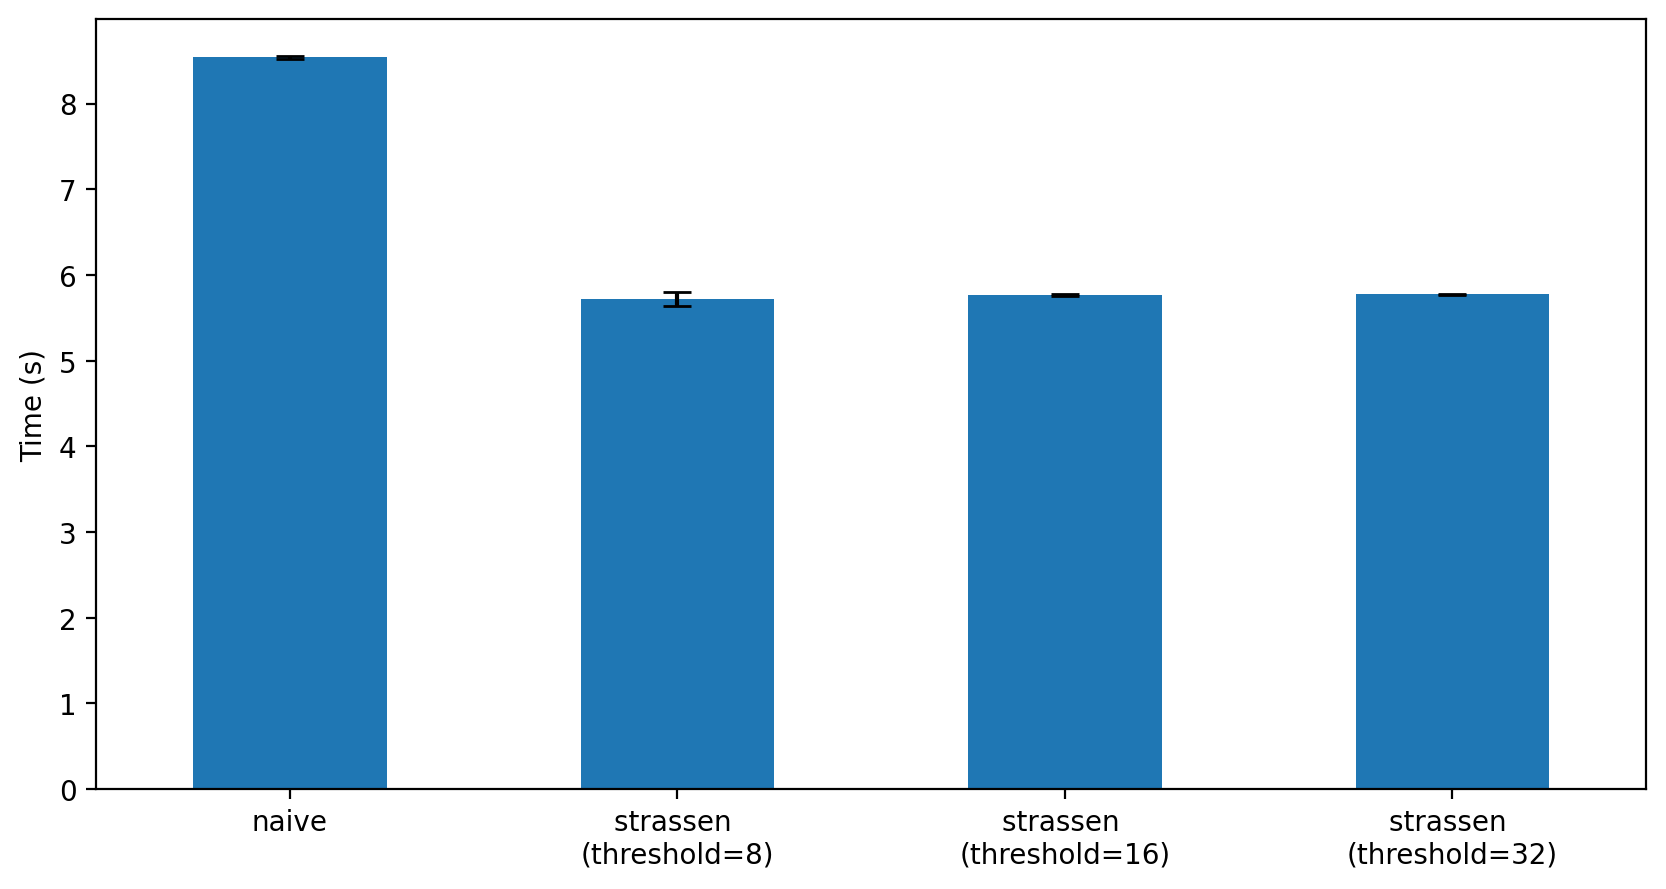

In [16]:
# Plot the results of the timing experiments as bar plot with mean and standard deviation
plt.figure(figsize=(10,5))
df = {}
df["naive"] = {"mean": naive_times.mean(), "std": naive_times.std()}
for threshold in thresholds:
    df[f"strassen \n(threshold={threshold})"] = {"mean": strassen_times[threshold].mean(), "std": strassen_times[threshold].std()}
df = pd.DataFrame(df).T

df["mean"].plot(kind="bar", yerr=df["std"], capsize=5, rot=0)
plt.ylabel("Time (s)")

In [17]:
# Directly multiply A and B usung numpy
numpy_times, C_numpy = run_and_time_multiplication(np.matmul, n_times, A, B)
print(f"NumPy Multiplication Times: {numpy_times.mean():0.3f} +/- {numpy_times.std():0.3f}")

NumPy Multiplication Times: 0.001 +/- 0.000
